In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df_movies = pd.read_csv('./drive/MyDrive/Colab Notebooks/movies.csv')

Mounted at /content/drive


In [3]:
df_movies.head()

,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."


In [4]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

#function for data cleaning and processing
#This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [5]:
print ('Cleaning and Tokenizing...')
%time df_movies['wiki_plot_tokenized'] = df_movies['wiki_plot'].map(lambda x: spacy_tokenizer(x))

df_movies.head()

Cleaning and Tokenizing...
CPU times: user 20.8 s, sys: 189 ms, total: 21 s
Wall time: 21 s


,rank,title,genre,wiki_plot,imdb_plot,wiki_plot_tokenized
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","[day, daughter, wed, vito, corleone, hear, req..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","[banker, andy, dufresne, convict, murder, wife..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"[germans, polish, jews, kraków, ghetto, world,..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","[brief, scene, age, overweight, italian, ameri..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...","[early, december, american, expatriate, rick, ..."


In [6]:
movie_plot = df_movies['wiki_plot_tokenized']
movie_plot[0:5]

0    [day, daughter, wed, vito, corleone, hear, req...
1    [banker, andy, dufresne, convict, murder, wife...
2    [germans, polish, jews, kraków, ghetto, world,...
3    [brief, scene, age, overweight, italian, ameri...
4    [early, december, american, expatriate, rick, ...
Name: wiki_plot_tokenized, dtype: object

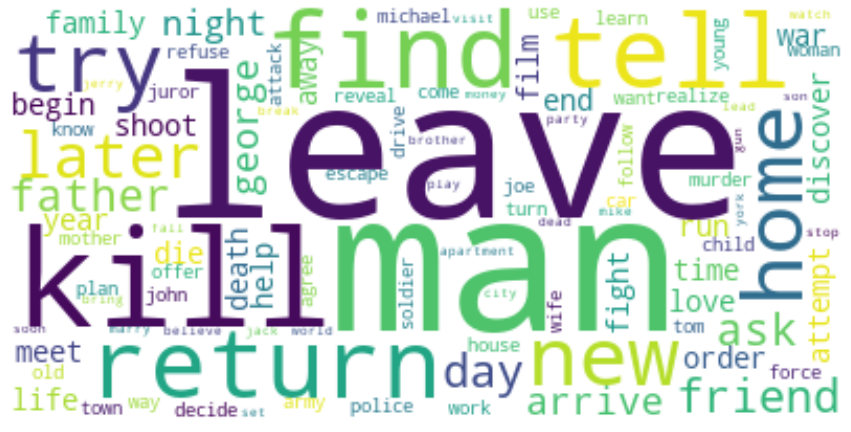

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(movie_plot)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
from gensim import corpora

#creating term dictionary
%time dictionary = corpora.Dictionary(movie_plot)

#filter out terms which occurs in less than 4 documents and more than 20% of the documents.
#NOTE: Since we have smaller dataset, we will keep this commented for now.

#dictionary.filter_extremes(no_below=4, no_above=0.2)

#list of few which which can be further removed
stoplist = set('hello and if this can would should could tell ask stop come go')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)

CPU times: user 56.4 ms, sys: 0 ns, total: 56.4 ms
Wall time: 78.5 ms


In [9]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['abrasive', 0], ['abroad', 1], ['abuse', 2], ['accept', 3], ['accuse', 4], ['act', 5], ['adams', 6], ['add', 7], ['address', 8], ['agree', 9], ['ambush', 10], ['angeles', 11], ['answer', 12], ['anthony', 13], ['apollonia', 14], ['arrange', 15], ['ask', 16], ['assassin', 17], ['assassination', 18], ['associate', 19], ['attack', 20], ['attempt', 21], ['authority', 22], ['aware', 23], ['baron', 24], ['barzini', 25], ['battle', 26], ['bed', 27], ['betrayal', 28], ['bodyguard', 29], ['bomb', 30], ['booth', 31], ['brasi', 32], ['brasis', 33], ['break', 34], ['bronx', 35], ['brother', 36], ['business', 37], ['buy', 38], ['capos', 39], ['captain', 40], ['car', 41], ['career', 42], ['carlo', 43], ['casino', 44], ['christening', 45], ['christmas', 46], ['clampdown', 47], ['clemenza', 48], ['collapse', 49], ['come', 50]]]


In [10]:
corpus = [dictionary.doc2bow(desc) for desc in movie_plot]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('abrasive', 2), ('abroad', 2), ('abuse', 4), ('accept', 6), ('accuse', 2), ('act', 2), ('adams', 3), ('add', 2), ('address', 2), ('agree', 2), ('ambush', 2), ('angeles', 2), ('answer', 2), ('anthony', 3), ('apollonia', 2), ('arrange', 2), ('ask', 2), ('assassin', 4), ('assassination', 4), ('associate', 2), ('attack', 4), ('attempt', 4), ('authority', 2), ('aware', 2), ('baron', 2), ('barzini', 7), ('battle', 2), ('bed', 2), ('betrayal', 2), ('bodyguard', 2), ('bomb', 2), ('booth', 2), ('brasi', 3), ('brasis', 2), ('break', 2), ('bronx', 2), ('brother', 6), ('business', 6), ('buy', 2), ('capos', 3), ('captain', 2), ('car', 2), ('career', 2), ('carlo', 7), ('casino', 2), ('christening', 4), ('christmas', 2), ('clampdown', 2), ('clemenza', 3), ('collapse', 2), ('come', 4), ('command', 2), ('confess', 2), ('confront', 2), ('connection', 2), ('connie', 6), ('consigliere', 5), ('contact', 2), ('corleone', 10), ('corleones', 4), ('corps', 3), ('coveted', 2), ('crime', 2), ('daughter', 2), 

In [11]:
%time movie_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time movie_lsi_model = gensim.models.LsiModel(movie_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 24.1 ms, sys: 941 µs, total: 25 ms
Wall time: 25.4 ms
CPU times: user 1.63 s, sys: 342 ms, total: 1.97 s
Wall time: 1.17 s


In [12]:
%time gensim.corpora.MmCorpus.serialize('movie_tfidf_model_mm', movie_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('movie_lsi_model_mm',movie_lsi_model[movie_tfidf_model[corpus]])

CPU times: user 127 ms, sys: 5.96 ms, total: 133 ms
Wall time: 135 ms
CPU times: user 116 ms, sys: 1.88 ms, total: 118 ms
Wall time: 117 ms


In [13]:
#Load the indexed corpus
movie_tfidf_corpus = gensim.corpora.MmCorpus('movie_tfidf_model_mm')
movie_lsi_corpus = gensim.corpora.MmCorpus('movie_lsi_model_mm')

print(movie_tfidf_corpus)
print(movie_lsi_corpus)

MmCorpus(100 documents, 8414 features, 25998 non-zero entries)
MmCorpus(100 documents, 100 features, 10000 non-zero entries)


In [14]:
from gensim.similarities import MatrixSimilarity

%time movie_index = MatrixSimilarity(movie_lsi_corpus, num_features = movie_lsi_corpus.num_terms)

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 14.1 ms


In [15]:
from operator import itemgetter

def search_similar_movies(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = movie_tfidf_model[query_bow]
    query_lsi = movie_lsi_model[query_tfidf]

    movie_index.num_best = 5

    movies_list = movie_index[query_lsi]

    movies_list.sort(key=itemgetter(1), reverse=True)
    movie_names = []

    for j, movie in enumerate(movies_list):

        movie_names.append (
            {
                'Relevance': round((movie[1] * 100),2),
                'Movie Title': df_movies['title'][movie[0]],
                'Movie Plot': df_movies['wiki_plot'][movie[0]]
            }

        )
        if j == (movie_index.num_best-1):
            break

    return pd.DataFrame(movie_names, columns=['Relevance','Movie Title','Movie Plot'])

In [17]:
# search for movie tiles that are related to below search parameters
search_similar_movies('comedy ')

,Relevance,Movie Title,Movie Plot
0,71.53,Raging Bull,"In a brief scene in 1964, an aging, overweight..."
1,68.49,Forrest Gump,"While waiting at a bus stop in 1981, Forrest G..."
2,0.00,The Philadelphia Story,\n \n Play media Play media Play media ...
3,-0.00,Butch Cassidy and the Sundance Kid,"In late 1890s Wyoming, Butch Cassidy (Paul New..."
4,-0.00,Ben-Hur,"In AD 26, Judah Ben-Hur (Charlton Heston) is a..."


In [18]:
# search for movie tiles that are related to below search parameters
search_similar_movies('action')

,Relevance,Movie Title,Movie Plot
0,67.44,Saving Private Ryan,"On the morning of June 6, 1944, the beginning ..."
1,37.26,On the Waterfront,Mob-connected union boss Johnny Friendly (Lee ...
2,27.62,Doctor Zhivago,The film takes place mostly against a backdrop...
3,22.77,A Place in the Sun,"] \n George Eastman (Montgomery Clift), th..."
4,22.73,American Graffiti,In late August 1962 recent high school graduat...


In [ ]:
# search for movie tiles that are related to below search parameters
search_similar_movies('')